In [1]:
%cd ..

/home/utanko/ondewo/ondewo-t2s


In [2]:
from inference.nemo_modules.inference_data_layer import InferenceDataLayer
import nemo
import nemo.collections.asr as nemo_asr
import nemo.collections.tts as nemo_tts
import wave
import numpy as np
from scipy.io.wavfile import write
import IPython
from pathlib import Path
from ruamel.yaml import YAML

from normalization.postprocessor import Postprocessor

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2020-10-08 10:48:45 audio_preprocessing:56] Could not import torchaudio. Some features might not work.
[NeMo W 2020-10-08 10:48:45 audio_preprocessing:61] Unable to import APEX. Mixed precision and distributed training will not work.
[NeMo W 2020-10-08 10:48:46 transformer_modules:36] Unable to import FusedLayerNorm  from APEX. Using regular LayerNorm instead.


In [3]:
from inference.nemo_synthesizer import NemoSynthesizer

yaml = YAML(typ="safe")
with open(Path("config", "ondewo_t2s_config.yaml")) as f:
    config = yaml.load(f)

nemo_synthesizer = NemoSynthesizer(config=config, load_waveglow=True)


Loaded Tacotron2 model.
Loaded WaveGlow model.
Loaded WaveGlow denoiser with strength 0.05.


In [4]:
texts=[#"Zu meiner Familie gehören vier Personen.", 
       #"Die Mutter bin ich und dann gehört natürlich mein Mann dazu.", 
       #"Wir haben zwei Kinder, einen Sohn, der sechs Jahre alt ist und eine dreijährige Tochter."]
       #"Hast du etwas Zeit für mich? Dann singe ich ein Lied."]
        "Die Zunahme der Arbeitslosigkeit ist im September etwas abgeflacht."]
       #"Texts include specialised articles, biographies and summaries."]
       #"I like to move it move it, I like to move it move it, we like to ... move it."]
       #"Der gemeinsam mit dem BioWare-Autorenteam von Star Wars The Old Republic."]
       #"When George Lucas finished the production of Star Wars VI, he cried."]
       #"I like tomatoes with tomato sauce and sausages."]

# make graph
data_layer = InferenceDataLayer(
    texts=texts,
    labels=nemo_synthesizer.labels,
    batch_size=2,
    num_workers=1,
    bos_id=nemo_synthesizer.bos_id,
    eos_id=nemo_synthesizer.eos_id,
    pad_id=nemo_synthesizer.pad_id,
    shuffle=False,
)

# building inference pipeline
transcript, transcript_len = data_layer()
transcript_embedded = nemo_synthesizer.tacotron_embedding(char_phone=transcript)
transcript_encoded = nemo_synthesizer.tacotron_encoder(char_phone_embeddings=transcript_embedded,
                                                      embedding_length=transcript_len, )
mel_decoder, gate, alignments, mel_len = nemo_synthesizer.tacotron_decoder(
    char_phone_encoded=transcript_encoded, encoded_length=transcript_len,
)
mel_postnet = nemo_synthesizer.tacotron_postnet(mel_input=mel_decoder)
audio_pred = nemo_synthesizer.waveglow(mel_spectrogram=mel_postnet)

# running the inference pipeline
evaluated_tensors = nemo_synthesizer.neural_factory.infer(
    tensors=[mel_postnet, gate, alignments, audio_pred, mel_len])

mel_len_result = evaluated_tensors[-1]
audio_result = evaluated_tensors[-2]

# WaveGlow

In [5]:
result = []
for i in range(len(mel_len_result)):
    for j in range(audio_result[i].shape[0]):
        sample_len = mel_len_result[i][j] * nemo_synthesizer.config['tacotron2']['config']["n_stride"]
        sample = audio_result[i].cpu().numpy()[j][:sample_len]

        if nemo_synthesizer.is_denoiser_active:
            sample, _ = nemo_synthesizer.waveglow.denoise(
                sample, strength = nemo_synthesizer.denoiser_strength)

        result.append(sample)


In [6]:
save_file = "notebooks/kerstin_generated_waveglow.wav"

audio = Postprocessor.postprocess(result)

# conversion to 16-bit PCM
audio *= np.iinfo(np.int16).max
audio = audio.astype("int16")

# save audio to file
write(save_file, 22050, audio)

In [7]:
print(audio.max(), audio.min(), audio.mean(), audio.std())

28446 -21794 0.24151413997449553 3169.713402761201


In [8]:
IPython.display.Audio(save_file)

# MelGAN https://github.com/descriptinc/melgan-neurips

In [9]:
from inference.melgan import MelGAN
ln_to_log10_const = np.log10(np.e)


# MelGAN
melgan_conf = {
    "input_size": 80,
    "ngf": 32,
    "n_residual_layers": 3,
    "device": "cuda",
    "load_path": "models/melgan/multi_speaker.pt"
}
melgan = MelGAN(melgan_conf)

mel_out = evaluated_tensors[0]
mel_list = [mel.cpu().numpy() for mel in mel_out[0]]

#mlst = [np.load("/home/utanko/ondewo/TensorFlowTTS/dump_ljspeech/train/raw-feats/LJ001-0001-raw-feats.npy").T]
mlst = np.load("notebooks/sample_0_11k.npy") * ln_to_log10_const
result_melgan = melgan.synthesize(mlst)


#result_melgan = melgan.synthesize(mel_list)

In [10]:
save_file = "notebooks/kerstin_generated_melgan.wav"

audio_melgan = Postprocessor.postprocess(result_melgan)

# conversion to 16-bit PCM
audio_melgan *= np.iinfo(np.int16).max
audio_melgan = audio_melgan.astype("int16")

# save audio to file
write(save_file, 22050, audio_melgan)

In [11]:
print(audio_melgan.max(), audio_melgan.min(), audio_melgan.mean(), audio_melgan.std())

12981 -10653 -1.424807969275084 1817.4140685797793


In [12]:
IPython.display.Audio(save_file)

# MelGAN (V2) https://github.com/seungwonpark/melgan

In [13]:
# MELGAN V2
import torch

vocoder = torch.hub.load('seungwonpark/melgan', 'melgan')
mel_list = np.array(mel_list)

print('Input mel-spectrogram shape: {}'.format(mel_list.shape))

if torch.cuda.is_available():
    print('Moving data & model to GPU')
    vocoder = vocoder.cuda()
    mel_list = torch.from_numpy(mel_list).cuda()

with torch.no_grad():
    audio = vocoder.inference(mel_list)
    #mlst = torch.from_numpy(np.array([np.load(
    #    "/home/utanko/ondewo/TensorFlowTTS/dump_ljspeech/train/raw-feats/LJ001-0001-raw-feats.npy"
    #).T])).cuda()
    mlst = torch.from_numpy(np.load("notebooks/sample_sandra.npy")).cuda()
    audio = vocoder.inference(mlst)

print('Output audio shape: {}'.format(audio.shape))

Input mel-spectrogram shape: (1, 80, 358)
Moving data & model to GPU


Using cache found in /home/utanko/.cache/torch/hub/seungwonpark_melgan_master


Output audio shape: torch.Size([149504])


In [14]:
save_file = "notebooks/kerstin_generated_melgan_v2.wav"

#audio_melgan = Postprocessor.postprocess([audio.cpu().numpy()])
audio_melgan = audio.cpu().numpy()

# conversion to 16-bit PCM
#audio_melgan *= np.iinfo(np.int16).max
#audio_melgan = audio_melgan.astype("int16")

# save audio to file
#write(save_file, 22050, audio_melgan)
import soundfile as sf
sf.write(save_file, audio_melgan, 22050, "PCM_16")

In [15]:
print(audio_melgan.max(), audio_melgan.min(), audio_melgan.mean(), audio_melgan.std())

23294 -22090 2.2199740475171232 3666.935834851313


In [16]:
IPython.display.Audio(save_file)

# MB-MelGAN https://github.com/TensorSpeech/TensorFlowTTS

In [3]:
import tensorflow as tf

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [33]:
"""
config = AutoConfig.from_pretrained("/home/utanko/ondewo/TensorFlowTTS/examples/multiband_melgan/conf/multiband_melgan.v1.yaml")
mb_melgan = TFAutoModel.from_pretrained(
    config=config, 
    pretrained_path="/home/utanko/ondewo/TensorFlowTTS/examples/multiband_melgan/mb_melgan.v1/checkpoints/generator-940000.h5", # "../examples/fastspeech2/checkpoints/model-150000.h5",
    is_build=True, # don't build model if you want to save it to pb. (TF related bug)
    name="mb_melgan"
)
"""

#config = AutoConfig.from_pretrained("/home/utanko/train.mb_melgan.ljspeech/config.yml")
config = AutoConfig.from_pretrained("/home/utanko/ondewo/TensorFlowTTS/examples/multiband_pwgan/conf/multiband_pwgan.v1.yaml")
mb_melgan = TFAutoModel.from_pretrained(
    config=config, 
    pretrained_path="/home/utanko/train.mb_melgan.ljspeech/checkpoints/generator-40000.h5", # "../examples/fastspeech2/checkpoints/model-150000.h5",
    is_build=True, # don't build model if you want to save it to pb. (TF related bug)
    name="mb_melgan"
)

In [97]:
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.mean_, scaler.scale_ = np.load("/home/utanko/ondewo/TensorFlowTTS/dump_ljspeech_0_8000/stats.npy")
scaler.n_features_in_ = 80

#mel_listt = np.swapaxes(mel_list.cpu().numpy(), 1, 2)[0]
#mel_listt = np.swapaxes(np.load("notebooks/sample_0_8k.npy"), 1, 2)[0]
mel_listt = np.load("notebooks/sample_florian.npy")[0].T * np.log10(np.e)
mel_listt = scaler.transform(mel_listt)

#mel_listt = np.load("/home/utanko/ondewo/TensorFlowTTS/dump_ljspeech_0_8000/train/raw-feats/LJ001-0001-raw-feats.npy")
#mel_listt = scaler.transform(mel_listt)

audios = mb_melgan.inference([mel_listt])
#audios = mb_melgan.inference([np.load("/home/utanko/ondewo/TensorFlowTTS/dump_ljspeech_0_8000/train/norm-feats/LJ001-0001-norm-feats.npy")])

In [98]:
#audio_melgan = np.load("/home/utanko/ondewo/TensorFlowTTS/dump_ljspeech/train/wavs/LJ001-0001-wave.npy")

In [99]:
save_file = "notebooks/kerstin_generated_mb_melgan.wav"

audio_melgan = audios[0, :, 0].numpy()

#audio_melgan *= np.iinfo(np.int16).max
#audio_melgan = audio_melgan.astype("int16")

# save audio to file
write(save_file, 22050, audio_melgan)

In [100]:
print(audio_melgan.max(), audio_melgan.min(), audio_melgan.mean(), audio_melgan.std())

0.649734 -0.54148126 1.5402202e-05 0.072565556


In [101]:
print(audio_melgan.max(), audio_melgan.min(), audio_melgan.mean(), audio_melgan.std())

0.649734 -0.54148126 1.5402202e-05 0.072565556


In [102]:
IPython.display.Audio(save_file)

In [54]:
mel_list.cpu().numpy()

NameError: name 'mel_list' is not defined

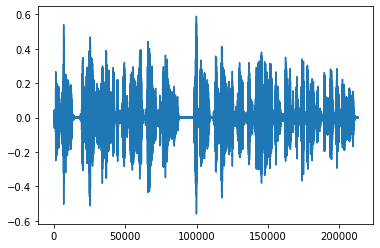

In [205]:
import matplotlib.pyplot as plt

plt.plot(audios[0, :, 0])